In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
import time


from DataGenerator import DataGenerator
from Models import Models
from LoadData import LoadData
from BaselineHelperFunctions import BaselineHelperFunctions
from RandomGridSearch import RandomGridSearch
from CustomCallback import CustomCallback
from MinMaxScalerFitter import MinMaxScalerFitter
from StandardScalerFitter import StandardScalerFitter

from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

from matplotlib.colors import ListedColormap

plt.rcParams["figure.figsize"]= (15,15)
helper = BaselineHelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


In [15]:
def y_to_sequence(y):
    label_dict = {'explosion':0, 'earthquake':1, 'noise':2, 'induced':3}
    y_seq = np.empty((len(y), 1))
    for idx, label in enumerate(y):
        y_seq[idx] = label_dict.get(label[0])
        
    return y_seq# Data Prep

# Data Prep

In [16]:
csv_root = 'csv_folder_3_class'
loadData = LoadData(csv_root, isBalanced = True)
shuffle = False
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)

In [17]:
test = False
detrend = False
sample_rate = 0.8

In [18]:
scalerFitter = StandardScalerFitter(train_ds)
scaler = scalerFitter.fit_scaler(test = test, detrend = detrend)

In [19]:
X_train, y_train = scalerFitter.transform_subsample(train_ds, subsample_rate = sample_rate, shuffle = shuffle, detrend = detrend)
X_val, y_val = scalerFitter.transform_subsample(val_ds, subsample_rate = sample_rate, shuffle = shuffle, detrend = detrend)
#X_train, y_train = scalerFitter.subsample(train_ds)
#X_val, y_val = scalerFitter.subsample(val_ds)

n_samples_train, channels, timesteps = X_train.shape
n_samples_val, _, _ = X_val.shape
X_train = X_train.reshape((n_samples_train, channels*timesteps))
X_val = X_val.reshape((n_samples_val, channels*timesteps))

y_train = y_to_sequence(y_train)
y_val = y_to_sequence(y_val)

In [7]:
print(y_train[:,0])

[ 2.  0.  0. ...,  1.  0.  2.]


## TSNE

In [11]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13155 samples in 66.906s...


KeyboardInterrupt: 

In [35]:
%matplotlib widget
N = 10000
df_subset = pd.DataFrame(tsne_results)
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y_train[:,0],
    palette=sns.color_palette("hls",3 ),
    data=df_subset,
    legend="full",
    alpha=1
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## PCA

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train)
df = pd.DataFrame(pca_result)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.18465647  0.11939073  0.11017058]


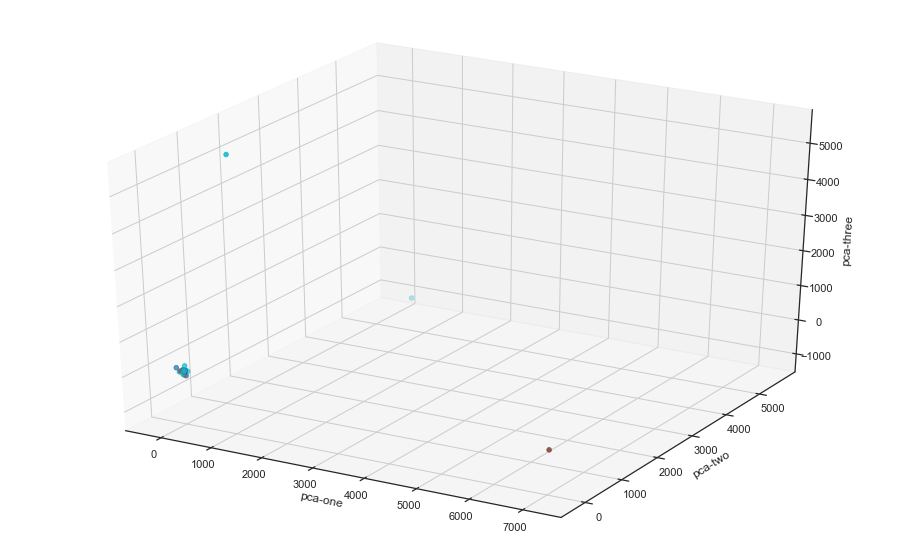

In [36]:

rndperm = np.random.permutation(df.shape[0])
%matplotlib inline

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=y_train[:,0], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()
